In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=6, processes=12) # necessary?
    w = cluster.scale(jobs=2)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.135:42399 Dashboard: http://10.148.0.135:8787/status,Cluster Workers: 24 Cores: 96 Memory: 223.44 GiB


___________
# 1. Read Zach's data, and store as .nc files every one hour (9415 .nc files) 

## !!!Note: Eta only has values at the ocean surface, so no dimension along depth (this is different from TSUVW)

In [4]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/'
# the path where the data will be re-stored
out_dir_nc = '/home1/scratch/xyu/OSMOSIS_llc4320/nc_file/'

# variable 
v = 'Eta'

In [5]:
# search for right files, for example: Theta_177x201x52.*
filenames = sorted(glob(LLC_data_folder+v+'/'+v+'_177x201.*')) 
print('Number of files processed: %d' %len(filenames))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames)):
#for i in np.arange(20):

    #
    file_out = out_dir_nc+'/%s_t%05d.nc'%(v, i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        ds = np.fromfile(filenames[i] , dtype='>f').reshape(201,177)
        ds = np.array(ds)
        ds = xr.DataArray(ds, dims=['lat','lon'])
        ds = np.real(ds).rename(v)
        ds = ds.load() # this may be required in order to prevent pickle related errors

        #
        while True:
            try:
                ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))

Number of files processed: 9415


# 2. Add coordinates and put variables into one xarray file

In [7]:
filenames = sorted(glob(out_dir_nc+v+'_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim="time",combine="nested")
print(ds)

Number of files processed: 9415
CPU times: user 25.8 s, sys: 4.6 s, total: 30.4 s
Wall time: 33.6 s
<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Dimensions without coordinates: lat, lon, time
Data variables:
    Eta      (time, lat, lon) float32 dask.array<chunksize=(1, 201, 177), meta=np.ndarray>


In [8]:
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [9]:
ds = ds.assign_coords(time=np.arange(len(filenames))*3600/86400) 
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat, lon
Data variables:
    Eta      (time, lat, lon) float32 dask.array<chunksize=(1, 201, 177), meta=np.ndarray>


In [11]:
chunks = {'time': 9415, 'lat': 201, 'lon': 177}
ds = ds.chunk(chunks)
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: lat, lon
Data variables:
    Eta      (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(9415, 201, 177)>


In [12]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

file_out = out_dir_zarr+'/%s_total_rechunk.zarr'%(v)
%time ds.to_zarr(file_out, mode='w')     

CPU times: user 23.4 s, sys: 984 ms, total: 24.4 s
Wall time: 37.1 s


In [28]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/'
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/'

In [29]:
LLC_XC = np.fromfile(LLC_data_folder+"grid/XC_177x201", dtype='>f').reshape(201,177)
LLC_XC = np.array(LLC_XC)
LLC_XC = xr.DataArray(LLC_XC, dims=['lat','lon'])
LLC_XC = np.real(LLC_XC).rename('LLC_XC')

In [30]:
LLC_YC = np.fromfile(LLC_data_folder+"grid/YC_177x201", dtype='>f').reshape(201,177)

LLC_YC = np.array(LLC_YC)
LLC_YC = xr.DataArray(LLC_YC, dims=['lat','lon'])
LLC_YC = np.real(LLC_YC).rename('LLC_YC')

In [31]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Surface_variable/'
ds = xr.open_zarr(out_dir_zarr+'Eta_total_rechunk.zarr')
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat, lon
Data variables:
    Eta      (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>


In [35]:
lat = LLC_YC.isel(lon=1)
lon = LLC_XC.isel(lat=1)
ds = ds.assign_coords(lat=lat) 
ds = ds.assign_coords(lon=lon)
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) >f4 47.4 47.42 47.43 47.44 47.46 ... 49.95 49.96 49.98 49.99
  * lon      (lon) >f4 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
Data variables:
    Eta      (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>


In [36]:
out_dir_nc = '/home1/scratch/xyu/OSMOSIS_llc4320/'

file_out = out_dir_nc+'Eta.nc'
print(ds)
%time ds.to_netcdf(file_out, mode='w')

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) >f4 47.4 47.42 47.43 47.44 47.46 ... 49.95 49.96 49.98 49.99
  * lon      (lon) >f4 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
Data variables:
    Eta      (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>
CPU times: user 184 ms, sys: 12 ms, total: 196 ms
Wall time: 2.68 s


In [37]:
Eta = xr.open_dataset(out_dir_nc+'Eta.nc')
Eta

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float32 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float32 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
Data variables:
    Eta      (time, lat, lon) float32 ...

# Read re-chunked data

In [9]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'


ds = xr.open_zarr(out_dir_zarr+v+'_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: lat, lon
Data variables:
    Eta      (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(9415, 201, 177)>

 data size: 1.3 GB


CPU times: user 204 ms, sys: 24 ms, total: 228 ms
Wall time: 3.24 s


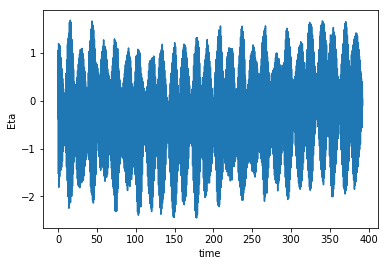

In [14]:
%time ds[v].isel(lat=slice(90,100), lon=slice(90,100)).mean(dim=['lat','lon']).plot()

In [13]:
OND = slice(433,2641)
JFM = slice(2641,4824)
AMJ = slice(4825,7008)
JAS = slice(7009,9216)

In [15]:
Eta_OND = ds.Eta.isel(time=OND)
Eta_OND = np.real(Eta_OND).rename('Eta_OND')
Eta_OND

<xarray.DataArray 'Eta_OND' (time: 2208, lat: 201, lon: 177)>
dask.array<shape=(2208, 201, 177), dtype=float32, chunksize=(2208, 201, 177)>
Coordinates:
  * time     (time) float64 18.04 18.08 18.12 18.17 18.21 18.25 18.29 18.33 ...
Dimensions without coordinates: lat, lon

In [16]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

file_out = out_dir_zarr+'Eta_surface_rechunk_OND.nc'
%time Eta_OND.to_netcdf(file_out, mode='w')   

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


CPU times: user 80 ms, sys: 8 ms, total: 88 ms
Wall time: 4.29 s


In [44]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
